## Q-learning / Reinforcement learning, example 3, FrozenLake, random grid layout

#### Imports + and make the environment

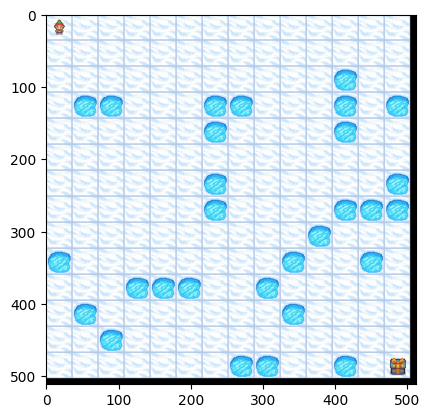

In [1]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# define a custom map, S => start, G => goal, F => normal ice tile, H => hole 
# you can also define a p-parameter for the percentage of holes in the map
# for example, p=0.8 => probability that tile is frozen => 80%, lower this to get more holes
custom_map = generate_random_map(size=14)


# episode effects, steps, comparisons, and bit more explanation needed

# create the FrozenLake environment, DISABLE SLIPPERY
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=custom_map)

# it would be logical to have width + height
# we have to double-check that we get the correct values in this order 
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())

### This time, we'll use Q-learning and reinforcement learning for the agent (elf) to move in the world!

In [ ]:
# I used a 14x14 randomly generated FrozenLake map. Q-learning was trained with Episodes: 30,000,
# Learning Rate: 0.1 and Discount Factor (Gamma): 0.9 along with Epsilon (Exploration Rate): Starts at 0.5, decays to 0.05
# The agent gradually learned to navigate through the environment. Reward trend showed a slow but steady increase in performance over time, eventually achieving consistent success.
# Same setup as Experiment 1, but increased epsilon to 0.9 and decay rate to 0.0005, encouraging more exploration early on.
# Learning was initially unstable due to frequent random actions, but the agent discovered better paths sooner and converged slightly faster toward optimal behavior.

# Rest of same experince as previous radom grid

# I saw if the grid is small one then Silppery does work even Agent took more steps to reach over the goal
# But if the envoirment is slippery and grid is more complex and there are more holes, then
# Agent took very very long steps, sometime it stuck in loop and could not able to go for next step.
# with slippery and complex goal, its sometime reached to goal with very long or too many stepps, but 90 percents 
# Agent could not reach the goal, and stuck with loop etc

In [2]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements are possible => up, right, down, left

Observation space:
Discrete(196)

Action space:
Discrete(4)


In [3]:
# the above information is used to generate an EMPTY Q-table!
# basically Q-table will hold the Quality-values (Q-values) for each possible action
# for each possible cell in the grid (basically we map out all possibilities in this environment)
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(196, 4)

## Q-learning formula:

#### Q(s, a) = Q(s, a) + alpha * (r + y * max(Q(s', a')) - Q(s, a))

In [4]:
# let's code the above equation into Q-learning update -function
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

### Helper function to visualize the highest Q-values in the grid

In [5]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)

In [6]:
# helper variables for our Q-learning training algorithm
# episode => how many times the AI tries to play the game as it learns

# learning rate (alpha) => usually good idea to start with 0.5, if the total rewards 
# of training are bouncing too much, try reducing slightly, for example, 0.35

# gamma => how much the AI values long-term rewards over short-term rewards
# gamma of 0.9 is very typical in basic Q-learning (a mix of short-term and long-rewards)

total_episodes = 30000

# how many steps our agent tries within one episode
# until we give up with that episode
max_steps = 50

learning_rate = 0.1
gamma = 0.9

# epsilon => not directly part of Q-learning update formula
# but used to determine how much our agent relies on current knowledge
# and how much the agent does wild guessing while training

# in ideal case => in the beginning of training => lots of guessing (high epsilon)
# but towards the end of training => less guessing and more trusting previous knowledge (smaller epsilon)
# in other words, we need guessing in the beginning so we can start learning at least something
# and towards the end there's no point guessing in the first steps of the environment, if we already
# know the optimal first steps in our current Q-table
epsilon = 0.5

# upper bound of our epsilon
max_epsilon = 0.2

# this is the lower bound, and our code is not going to decay the epsilon below this
min_epsilon = 0.05
decay_rate = 0.0001

### Train the agent with a for-loop (based on episodes)

#### NOTE! This grid is already much more complex, and a simple policy where we only use the +1 reward for goal is not going to cut, we need to fine-tune the policy

In [7]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # => we get initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    # WITHIN this episode of playing the game, play as long as our max steps define
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

        # PHASE 1: determine the next action!
        # use epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        # epsilon -> should we EXPLOIT our current knowledge or explore (wild guess)
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # let's explore => random action
            action = env.action_space.sample()


        # PHASE 2: get the results from the action done in PHASE 1
        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        # PHASE 3.1 -> punish the agent for making a move -> a very small adjustment
        # this will eventually guide the agent to choose the shortest path with least moves
        reward = reward - 0.01

        # PHASE 3.2 => if the agent drops into a hole => PUNISH HEAVILY
        # basically if game over is true and reward is 0 or less => game over with hole
        # if agent drops into a hole, we just adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break
            
        # PHASE 3.3: update the Q-table with the values we have right now
        # NOTE: this phase will be skipped if the agent dropped down a hole in previous section
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # PHASE 5: check if we have either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            # # little bit of debugging of the current version of the Q-table
            # if total_rewards > 0 and step % 6 == 0:
            #     print(f"Current Q-table - Episode: {episode}")
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # FINAL PHASE: AFTER THE EPISODE -> apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # only print the result if our rewards are positive
    if total_rewards >= 0:
        print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

Steps taken: 48
Episode 944 done with total rewards: 0.5099999999999998, epsilon: 0.18648780829231748
Steps taken: 48
Episode 1132 done with total rewards: 0.5099999999999998, epsilon: 0.18394580717687226
Steps taken: 47
Episode 1167 done with total rewards: 0.5199999999999998, epsilon: 0.18347781631350463
Steps taken: 41
Episode 1234 done with total rewards: 0.5799999999999998, epsilon: 0.18258650417411876
Steps taken: 47
Episode 1248 done with total rewards: 0.5199999999999998, epsilon: 0.1824010129424341
Steps taken: 38
Episode 1311 done with total rewards: 0.6099999999999999, epsilon: 0.1815695085499321
Steps taken: 49
Episode 1323 done with total rewards: 0.4999999999999997, epsilon: 0.18141171983183768
Steps taken: 45
Episode 1352 done with total rewards: 0.5399999999999998, epsilon: 0.18103117789682754
Steps taken: 34
Episode 1354 done with total rewards: 0.6499999999999999, epsilon: 0.18100497428169704
Steps taken: 45
Episode 1369 done with total rewards: 0.5399999999999998, ep

### Let's study the final optimal Q-table for our grid

In [8]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
# so in the first row best values are 1 and 2 => basically it doesn't matter
# if we go down or right from the first cell

# however, this is quite hard to visualize already, see the next version below

array([[-0.02957421, -0.02174912, -0.02174912, -0.02957421],
       [-0.02957421, -0.01305458, -0.05271785, -0.03567524],
       [-0.08107631, -0.07557598, -0.0106734 , -0.07464418],
       [-0.0762656 ,  0.0070734 , -0.07866273, -0.06364009],
       [-0.06965329, -0.07697596, -0.07687801, -0.07713591],
       [-0.0752551 , -0.07507923, -0.0750939 , -0.07531373],
       [-0.07368247, -0.07312748, -0.07318489, -0.07326387],
       [-0.07159523, -0.07130663, -0.07115161, -0.07119306],
       [-0.06931103, -0.06920038, -0.06931538, -0.06948141],
       [-0.06765201, -0.06762259, -0.06748537, -0.06739565],
       [-0.06593893, -0.06594941, -0.06594183, -0.06583494],
       [-0.06452645, -0.06461142, -0.0644673 , -0.06425135],
       [-0.06317635, -0.06319584, -0.06339056, -0.06314466],
       [-0.06264756, -0.06285322, -0.06275944, -0.06289215],
       [-0.02174912, -0.01305458, -0.01305458, -0.02957421],
       [-0.02700877, -0.01854259, -0.00339397, -0.03564127],
       [-0.02774884, -0.

In [9]:
# ... we need a helper function for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.021749,-0.013055,-0.010673,0.007073,-0.069653,-0.075079,-0.073127,-0.071152,-0.069200,-0.067396,-0.065835,-0.064251,-0.063145,-0.062648
1,-0.013055,-0.003394,0.007340,0.019267,-0.013842,-0.074025,-0.072300,-0.070341,-0.068572,-0.066882,-0.065368,-0.063881,-0.062562,-0.062103
2,-0.003394,0.007340,0.019267,0.032519,0.008487,-0.070386,-0.071132,-0.069349,-0.067164,-0.065603,-0.064580,0.000000,-0.061149,-0.061666
3,0.007340,0.000000,0.000000,0.047243,0.040692,-0.058253,0.000000,0.000000,-0.064750,-0.063896,-0.063238,0.000000,-0.059234,0.000000
4,0.019267,0.032519,0.046171,0.063603,0.080294,-0.011475,0.000000,-0.061074,-0.062211,-0.062160,-0.061386,0.000000,-0.057331,-0.056424
5,0.032519,0.047243,0.063597,0.081781,0.101955,0.102226,-0.062443,-0.057254,-0.059130,-0.059757,-0.059225,-0.057318,-0.056844,-0.056213
6,0.047243,0.063603,0.081781,0.101979,0.124421,0.149357,0.000000,-0.041768,-0.047988,-0.057892,-0.057540,-0.056752,-0.056130,0.000000
7,0.063603,0.081781,0.101979,0.124421,0.149357,0.177063,0.000000,0.193618,0.016638,-0.052982,-0.056662,0.000000,0.000000,0.000000
8,0.081781,0.101979,0.124421,0.149357,0.177063,0.207848,0.242054,0.280059,0.158871,-0.051529,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.081781,0.101979,0.177063,0.207848,0.242054,0.280059,0.322288,0.264430,0.000000,-0.001179,-0.001900,0.000000,0.000000


### Finally, let's allow our Q-learning -based AI to play the game with the optimized Q-table!

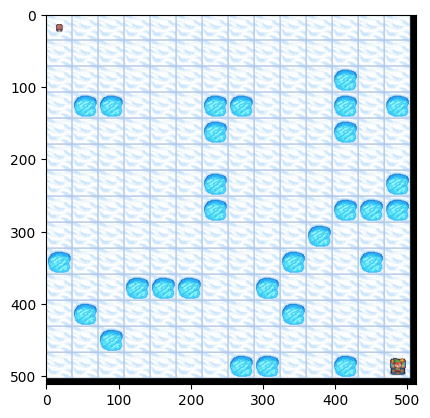

Episode: 5 done with total_rewards: 1.0


: 

In [ ]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(0.3)

### Well done ELF (...yet again)!